# Objective
The objetive of this notebook is to replicate example of section 12.4 https://otexts.com/fpp3/nnetar.html.

# Description of the data
The dataset contais data about sun spots. The surface of the sun contains magnetic regions that appear as dark spots. 

# Imports, configuration and constants

In [1]:
from os import path
from typing import Optional
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.neural_network import MLPRegressor

plt.rc("figure", figsize=(16, 6))
plt.rc("font", size=13)

In [2]:
PLOT_TITLE = "Yearly sunspots"
PLOT_YLABEL = "Counts"
PLOT_XLABEL = "Year"

# Functions

In [93]:
def plot_sunspots_ts(
    ts: pd.Series, 
    start_time: str = None, 
    end_time: str = None,
    lower_ci: pd.Series = None, 
    upper_ci: pd.Series = None
):
    
    if start_time is not None:
        ts = ts[ts.index >= start_time]
        lower_ci = lower_ci[ts.index]
        upper_ci = upper_ci[ts.index]
        
    if end_time is not None:
        ts = ts[ts.index <= end_time]
        lower_ci = lower_ci[ts.index]
        upper_ci = upper_ci[ts.index]
    
    x = ts.index
    y = ts
    
    plt.plot(x, y)
    
    if lower_ci is not None and upper_ci is not None:
        plt.fill_between(x, lower_ci, upper_ci, alpha=0.2, label='Confidence Interval')
        plt.legend(loc='upper left')
    
    plt.xticks(rotation=70)
    plt.xlabel(PLOT_XLABEL)
    plt.ylabel(PLOT_YLABEL)
    plt.title(PLOT_TITLE)
    plt.show()
    

def _filter_time_series(
    ts: pd.Series, 
    start_time: str = None, 
    end_time: str = None
) -> pd.Series:
        
    if start_time is not None:
        ts = ts[ts.index >= start_time]
    if end_time is not None:
        ts = ts[ts.index <= end_time]
    return ts 


def _prepare_labels(n_ts: int, labels: Optional[list[str]]) -> list[str]:
    """
    Create labels if they are None.
    """

    if labels:
        return labels

    labels = list()
    for i in range(n_ts):
        labels.append(f'TS {i+1}')

    return labels


def _get_color(index: int) -> str:
    """
    Get a color based on an index.
    """
    colors = ['k', 'b', 'r', 'g'] # Add more colors as needed
    return colors[index % len(colors)]


def _plot_single_ts_on_axis(
    ax: plt.Axes, 
    ts: pd.Series, 
    color: str, 
    label: str,
    lower_ci: pd.Series = None, 
    upper_ci: pd.Series = None,
):
    """
    Plot a time series and CI on an axis with a given color and label.
    """
    
    ax.plot(ts.index, ts.values, color=color, label=label)
    
    if lower_ci is not None and upper_ci is not None:
        ax.fill_between(
            ts.index, 
            lower_ci, 
            upper_ci, 
            alpha=0.2, 
            color=color, 
            label=f'{label} Confidence Interval'
        )
        
def _set_plot_properties(add_legend=True):
    """
    Set properties for the plot.
    """
    
    plt.xticks(rotation=70)
    plt.xlabel(PLOT_XLABEL)
    plt.ylabel(PLOT_YLABEL)
    plt.title(PLOT_TITLE)
    
    if add_legend:
        plt.legend(loc='upper left')
        
        
def plot_multiple_ts(
    ts_list: list[pd.Series],
    start_time: str = None,
    end_time: str = None,
    lower_ci_list: Optional[list[pd.Series]] = None,
    upper_ci_list: Optional[list[pd.Series]] = None,
    labels: Optional[list[str]] = None,
):
    """
    Plot multiple time series predictions with their respective confidence intervals on the same plot.
    """
    
    labels = _prepare_labels(len(ts_list), labels)
    
    fig, ax = plt.subplots()
    
    for i in range(len(ts_list)):
        
        ts = ts_list[i]
        ts = _filter_time_series(ts, start_time, end_time)
        
        lower_ci = None
        if lower_ci_list and lower_ci_list[i] is not None:
            lower_ci = lower_ci_list[i]
            lower_ci = _filter_time_series(lower_ci, start_time, end_time)
        
        upper_ci = None
        if upper_ci_list and upper_ci_list[i] is not None:
            upper_ci = upper_ci_list[i]
            upper_ci = _filter_time_series(upper_ci, start_time, end_time)
            
        color = _get_color(i)
        label = labels[i]
        
        _plot_single_ts_on_axis(ax, ts, color, label, lower_ci, upper_ci)

    _set_plot_properties()
    plt.show()    

# Load data

In [4]:
data_dir_path = "../data-raw/"
sunsposts_path = path.join(data_dir_path, "sunspots.csv")

df = pd.read_csv(sunsposts_path, sep='|')
df.columns = df.columns.str.lower()

df = df.rename(columns={"index": "year", "value": "counts"})

In [5]:
df.head()

,year,counts
0,1700,5.0
1,1701,11.0
2,1702,16.0
3,1703,23.0
4,1704,36.0


In [7]:
df.counts

0        5.0
1       11.0
2       16.0
3       23.0
4       36.0
       ...  
284     45.9
285     17.9
286     13.4
287     29.2
288    100.2
Name: counts, Length: 289, dtype: float64

# Forecasting

In [8]:
ts = pd.Series(df.counts.tolist(), index=df.year)
ts.head()

year
1700     5.0
1701    11.0
1702    16.0
1703    23.0
1704    36.0
dtype: float64

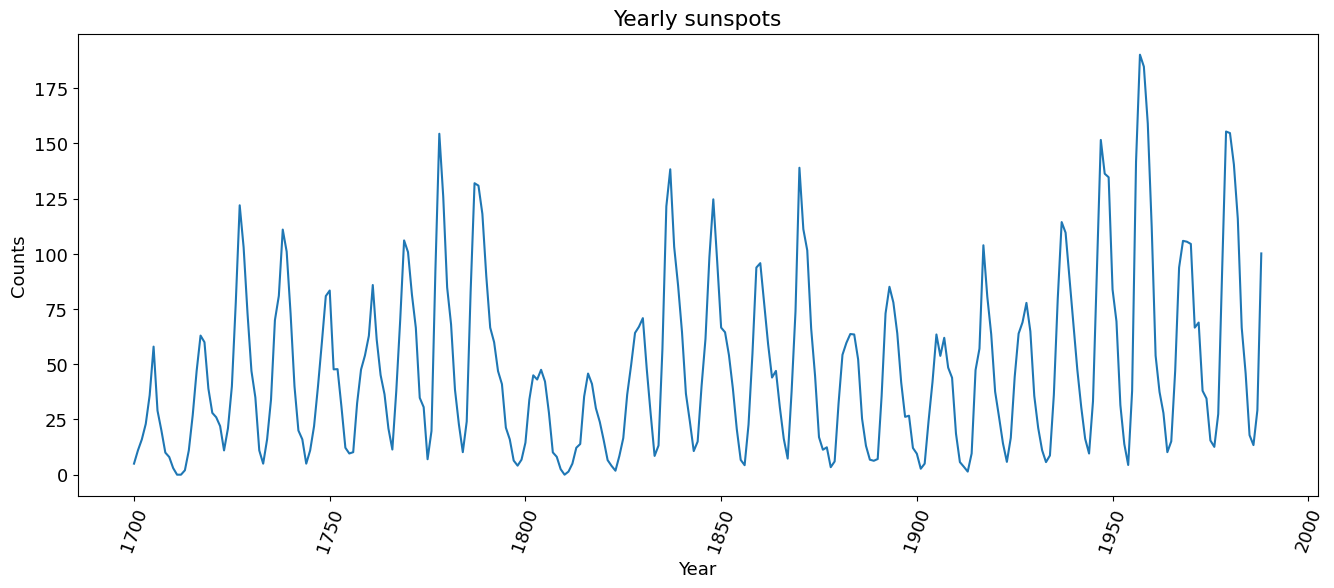

In [9]:
plot_sunspots_ts(ts)

In [10]:
ts_sqrt = np.sqrt(ts)

In [11]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        
        super(Net, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        
        x = torch.relu(self.hidden(x))
        x = self.output(x)
        return x

    def train(self, trainloader, num_epochs, lr=1e-4):
        
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)

        for epoch in range(num_epochs):
            running_loss = 0.0
            for inputs, targets in trainloader:
                
                inputs = inputs.float()
                targets = targets.float()
                targets = targets.reshape((targets.shape[0], 1))
                
                optimizer.zero_grad()

                outputs = self(inputs)
                loss = criterion(outputs, targets)

                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                
            print(f"Epoch {epoch+1}, loss: {running_loss/len(trainloader)}")

    def predict(self, predict_data):
        
        with torch.no_grad():
            predict_data = predict_data.float()
            outputs = self(predict_data)
            return outputs
        
    def predict_iteratively(self, initial_data: torch.Tensor, n_preds: int):
    
        predict_data = initial_data

        preds = []
        for _ in range(n_preds):
            pred = net.predict(predict_data)
            predict_data = torch.cat((pred, predict_data[:-1]))
            preds.append(pred.item())

        return preds

In [12]:
class SunspotsDataset(torch.utils.data.Dataset):
    """
    Prepare the Boston dataset for regression
    """

    def __init__(self, lagged_data_df: pd.DataFrame):
        
        # Split the lagged data into input and output arrays
        X = lagged_data_df.iloc[:, 1:].values
        y = lagged_data_df.iloc[:, 0].values
    
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [13]:
def create_lagged_data(series, N):
    
    # Create a DataFrame from the series
    data = pd.DataFrame(series)
    # Shift the original data to create the lagged data
    lagged_data = pd.concat([data.shift(i) for i in range(N+1)], axis=1).dropna()
    lagged_data.columns = ['t'] + [f't-{i}' for i in range(1, N+1)]
    return lagged_data


In [14]:
N = 9
lagged_data_df = create_lagged_data(ts_sqrt, N)

In [15]:
lagged_data_df

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9
year,,,,,,,,,,
1709,2.828427,3.162278,4.472136,5.385165,7.615773,6.000000,4.795832,4.000000,3.316625,2.236068
1710,1.732051,2.828427,3.162278,4.472136,5.385165,7.615773,6.000000,4.795832,4.000000,3.316625
1711,0.000000,1.732051,2.828427,3.162278,4.472136,5.385165,7.615773,6.000000,4.795832,4.000000
1712,0.000000,0.000000,1.732051,2.828427,3.162278,4.472136,5.385165,7.615773,6.000000,4.795832
1713,1.414214,0.000000,0.000000,1.732051,2.828427,3.162278,4.472136,5.385165,7.615773,6.000000
...,...,...,...,...,...,...,...,...,...,...
1984,6.774954,8.160882,10.765686,11.853270,12.437845,12.465954,9.617692,5.244044,3.549648,3.937004
1985,4.230839,6.774954,8.160882,10.765686,11.853270,12.437845,12.465954,9.617692,5.244044,3.549648
1986,3.660601,4.230839,6.774954,8.160882,10.765686,11.853270,12.437845,12.465954,9.617692,5.244044


In [16]:
dataset = SunspotsDataset(lagged_data_df)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

In [17]:
# Define the input, hidden, and output sizes
input_size = N
hidden_size = 5
output_size = 1

# Create an instance of the neural network
net = Net(input_size, hidden_size, output_size)

In [32]:
n_epochs = 100
lr = 1e-3

net.train(trainloader, n_epochs, lr=lr)

Epoch 1, loss: 1.1675745670665363
Epoch 2, loss: 1.1596639279278373
Epoch 3, loss: 1.1594765476215245
Epoch 4, loss: 1.1591555613165188
Epoch 5, loss: 1.1586768486011612
Epoch 6, loss: 1.158221623707066
Epoch 7, loss: 1.1577864848254324
Epoch 8, loss: 1.1573668525713336
Epoch 9, loss: 1.1566243110521823
Epoch 10, loss: 1.156524653156118
Epoch 11, loss: 1.1558312962294621
Epoch 12, loss: 1.1557548168372778
Epoch 13, loss: 1.1550891607375693
Epoch 14, loss: 1.1550258160315219
Epoch 15, loss: 1.1543860403357646
Epoch 16, loss: 1.153391737907376
Epoch 17, loss: 1.1538446229719348
Epoch 18, loss: 1.1533838911503673
Epoch 19, loss: 1.1530328643317256
Epoch 20, loss: 1.152107410622371
Epoch 21, loss: 1.1525690893714098
Epoch 22, loss: 1.1518009837424943
Epoch 23, loss: 1.1514888587157073
Epoch 24, loss: 1.1511986773802683
Epoch 25, loss: 1.1509184955499483
Epoch 26, loss: 1.1506443334981409
Epoch 27, loss: 1.150122223965744
Epoch 28, loss: 1.1506125675483807
Epoch 29, loss: 1.1498939641234756

In [19]:
lagged_data_df.tail()

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9
year,,,,,,,,,,
1984,6.774954,8.160882,10.765686,11.853270,12.437845,12.465954,9.617692,5.244044,3.549648,3.937004
1985,4.230839,6.774954,8.160882,10.765686,11.853270,12.437845,12.465954,9.617692,5.244044,3.549648
1986,3.660601,4.230839,6.774954,8.160882,10.765686,11.853270,12.437845,12.465954,9.617692,5.244044
1987,5.403702,3.660601,4.230839,6.774954,8.160882,10.765686,11.853270,12.437845,12.465954,9.617692
1988,10.009995,5.403702,3.660601,4.230839,6.774954,8.160882,10.765686,11.853270,12.437845,12.465954


In [62]:
# Use the last observations as input
initial_data = torch.from_numpy(np.array(lagged_data_df.iloc[-1][:-1]))
initial_data

tensor([10.0100,  5.4037,  3.6606,  4.2308,  6.7750,  8.1609, 10.7657, 11.8533,
        12.4378], dtype=torch.float64)

In [36]:
type(initial_data)

torch.Tensor

In [21]:
N_PREDS = 30
preds = net.predict_iteratively(initial_data, N_PREDS)

In [22]:
last_year = lagged_data_df.index[-1]
h_index = range(last_year+1, last_year+N_PREDS+1)

ts_h = np.power(pd.Series(preds, index=h_index), 2)
ts_with_h = pd.concat([ts, ts_h])

In [23]:
ts_with_h

1700     5.000000
1701    11.000000
1702    16.000000
1703    23.000000
1704    36.000000
          ...    
2014    89.021932
2015    61.307286
2016    39.645410
2017    28.381061
2018    27.228743
Length: 319, dtype: float64

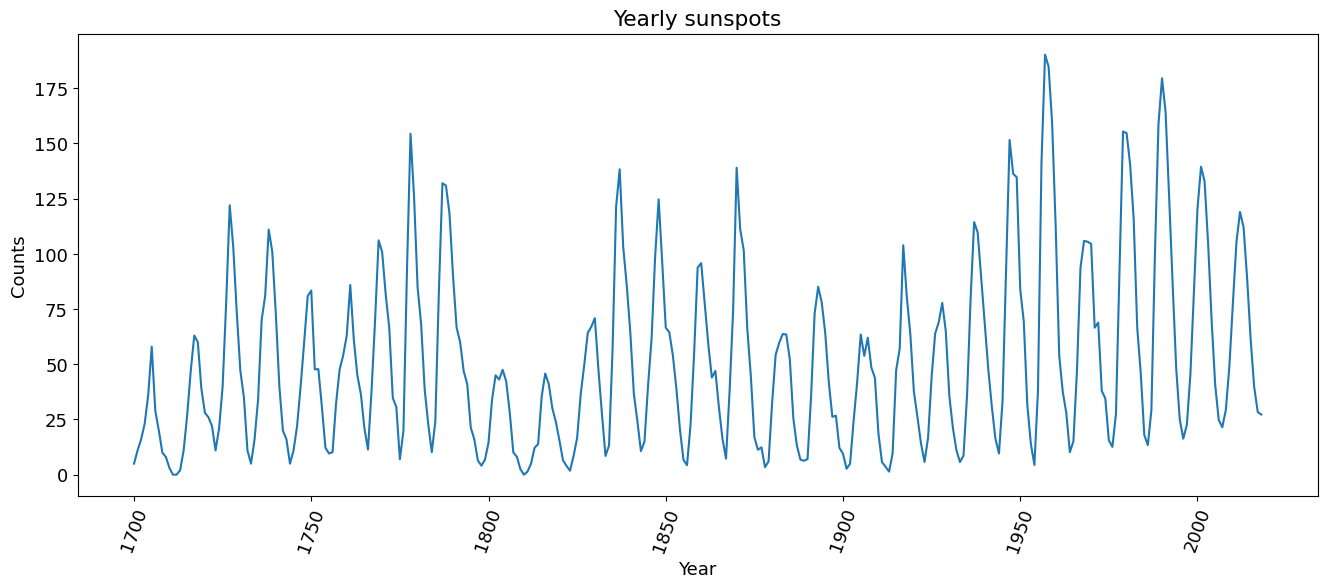

In [24]:
plot_sunspots_ts(ts_with_h)

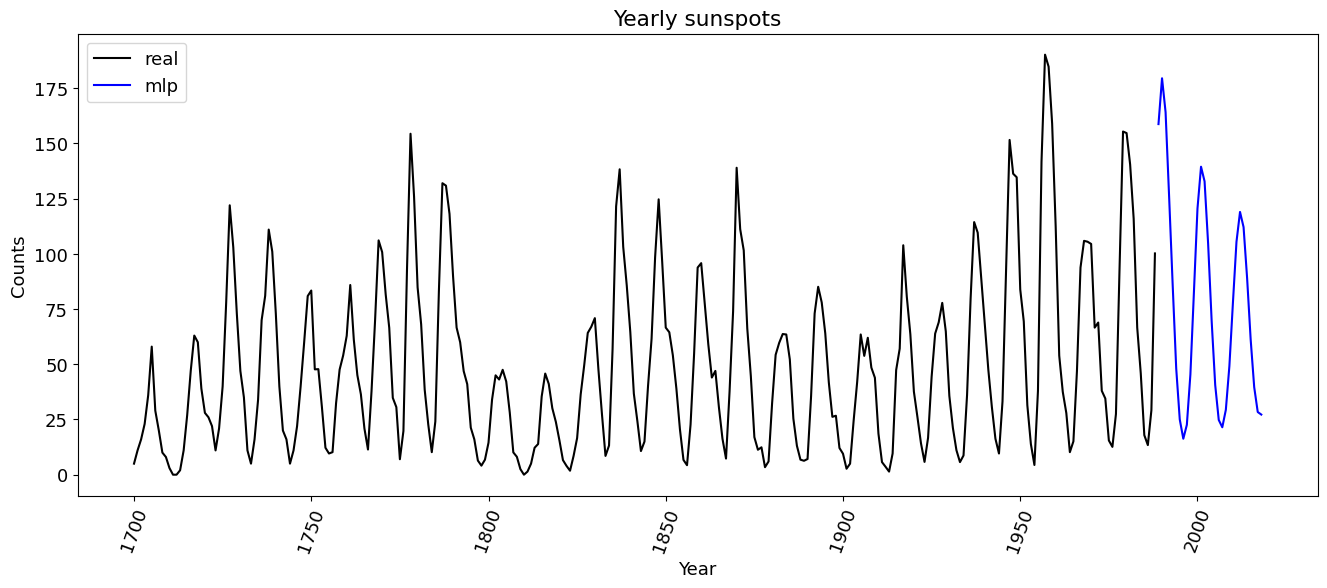

In [25]:
labels = ["real", "mlp",]

plot_multiple_ts([ts, ts_h], labels=labels)

### Checking that a sklearn does a similar job

In [55]:
X = dataset.X.numpy()
y = dataset.y.numpy()

mlp = MLPRegressor(
    # random_state=1, 
    max_iter=n_epochs, 
    hidden_layer_sizes=(hidden_size,),
    learning_rate_init=lr,
    batch_size=1
)

mlp.fit(X, y);

/home/santiagopalmero/.pyenv/versions/3.10.5/envs/fpp3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [48]:
def predict_iteratively(mlp: MLPRegressor, initial_data: np.array, n_preds: int) -> list[float]:
    
    predict_data = initial_data
    preds = []
    for _ in range(N_PREDS):
        pred = mlp.predict([predict_data])
        predict_data = np.hstack((pred, predict_data[:-1]))
        preds.append(pred[0])
        
    return preds

In [56]:
mlp_initial_data = np.array(lagged_data_df.iloc[-1][:-1])
mlp_preds = predict_iteratively(mlp, initial_data, N_PREDS)
ts_mlp_h = np.power(pd.Series(mlp_preds, index=h_index), 2)

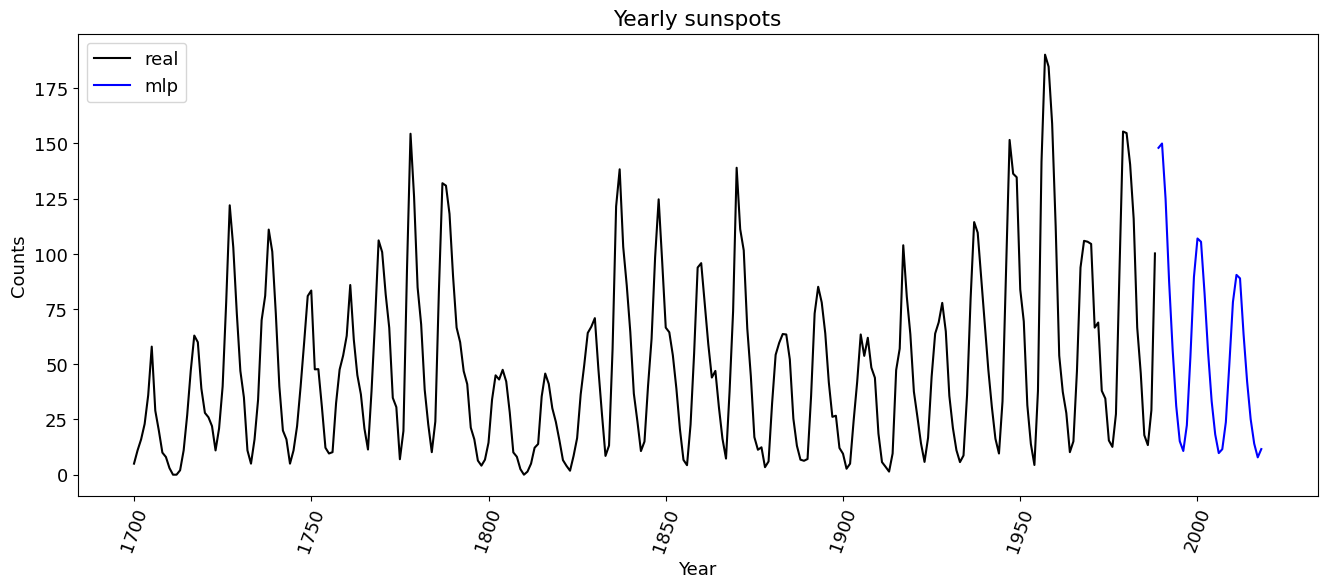

In [58]:
plot_multiple_ts([ts, ts_mlp_h], labels=labels)

### Future paths

In [59]:
lagged_data_df.tail()

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9
year,,,,,,,,,,
1984,6.774954,8.160882,10.765686,11.853270,12.437845,12.465954,9.617692,5.244044,3.549648,3.937004
1985,4.230839,6.774954,8.160882,10.765686,11.853270,12.437845,12.465954,9.617692,5.244044,3.549648
1986,3.660601,4.230839,6.774954,8.160882,10.765686,11.853270,12.437845,12.465954,9.617692,5.244044
1987,5.403702,3.660601,4.230839,6.774954,8.160882,10.765686,11.853270,12.437845,12.465954,9.617692
1988,10.009995,5.403702,3.660601,4.230839,6.774954,8.160882,10.765686,11.853270,12.437845,12.465954


As explained in https://otexts.com/fpp3/nnetar.html#prediction-intervals-5 and https://otexts.com/fpp3/prediction-intervals.html#prediction-intervals-from-bootstrapped-residuals we are going to assume that the residuals are uncorrelated with constant variance. Under this assumption we are going to sample past errors (the residuals). 

In [60]:
# Get a sample of historical errors
historical_errors = []
for inputs, targets in trainloader:
    outputs = net.predict(inputs)
    
    error = targets.item() - outputs.item()
    historical_errors.append(error)

In [61]:
np.random.choice(historical_errors)

-1.3017143280562884

In [ ]:
import numpy as np

# Create a list
my_list = [1, 2, 3, 4, 5]

# Sample one item from the list
random_item = np.random.choice(my_list)

# Print the sampled item
print(random_item)

In [63]:
net.predict(initial_data)

tensor([12.6077])

In [67]:
torch.Tensor([historical_errors[0]]) + torch.Tensor([historical_errors[0]])

tensor([-0.8829])

In [74]:
# TODO: ACABAR FUTURE SAMPLE PATH
def predict_future_paths(
    net, n_paths: int, initial_data: torch.Tensor, n_preds: int, historical_errors: list[float]
):
    
    future_paths = [
        predict_future_path(net, initial_data, n_preds, historical_errors)
        for _ in range(n_paths)
    ]
    
    return future_paths
        

def predict_future_path(net, initial_data: torch.Tensor, n_preds: int, historical_errors: list[float]):

    predict_data = initial_data

    future_path = []
    for _ in range(n_preds):
        pred = net.predict(predict_data)
        
        hist_error = np.random.choice(historical_errors)
        hist_error = torch.Tensor([hist_error])
        
        future_value = pred + hist_error
        
        predict_data = torch.cat((future_value, predict_data[:-1]))
        future_path.append(future_value.item())

    return future_path

In [70]:
future_path = predict_future_path(net, initial_data, N_PREDS, historical_errors)

In [72]:
ts_future_h = np.power(pd.Series(future_path, index=h_index), 2)

In [75]:
future_paths = predict_future_paths(net, 5, initial_data, N_PREDS, historical_errors)

In [77]:
ts_futures_h = []
for future_path in future_paths:
    ts_future_h = np.power(pd.Series(future_path, index=h_index), 2)
    
    ts_futures_h.append(ts_future_h)

In [82]:
def _get_color(index: int) -> str:
    """
    Get a color based on an index.
    """
    colors = ['k', 'b', 'r', 'g', 'c', 'm', 'y'] + ['orange', 'pink', 'purple', 'brown', 'gray', 'navy', 'olive', 'teal'] * 3 # Add more colors as needed
    return colors[index % len(colors)]

In [85]:
np.array(future_paths).shape

(5, 30)

In [87]:
future_paths

[[13.04601764678955,
  12.970623970031738,
  13.235767364501953,
  11.178394317626953,
  9.422386169433594,
  6.82484245300293,
  6.083559989929199,
  5.146250247955322,
  5.819965362548828,
  6.825842380523682,
  7.306238174438477,
  7.781285285949707,
  9.39891242980957,
  11.474888801574707,
  11.74296760559082,
  10.775428771972656,
  7.8388214111328125,
  5.31773567199707,
  4.359593391418457,
  2.4844741821289062,
  3.677292585372925,
  5.179252624511719,
  6.2686686515808105,
  8.11658000946045,
  9.993773460388184,
  11.053361892700195,
  9.228096008300781,
  8.016512870788574,
  5.3064680099487305,
  3.881899118423462],
 [13.220558166503906,
  15.006507873535156,
  14.895722389221191,
  12.149042129516602,
  10.042140007019043,
  6.735755920410156,
  4.482398986816406,
  2.9870996475219727,
  3.821160316467285,
  4.806121826171875,
  6.1826605796813965,
  8.004631042480469,
  10.581134796142578,
  10.926413536071777,
  11.115793228149414,
  8.69925308227539,
  5.70055961608886

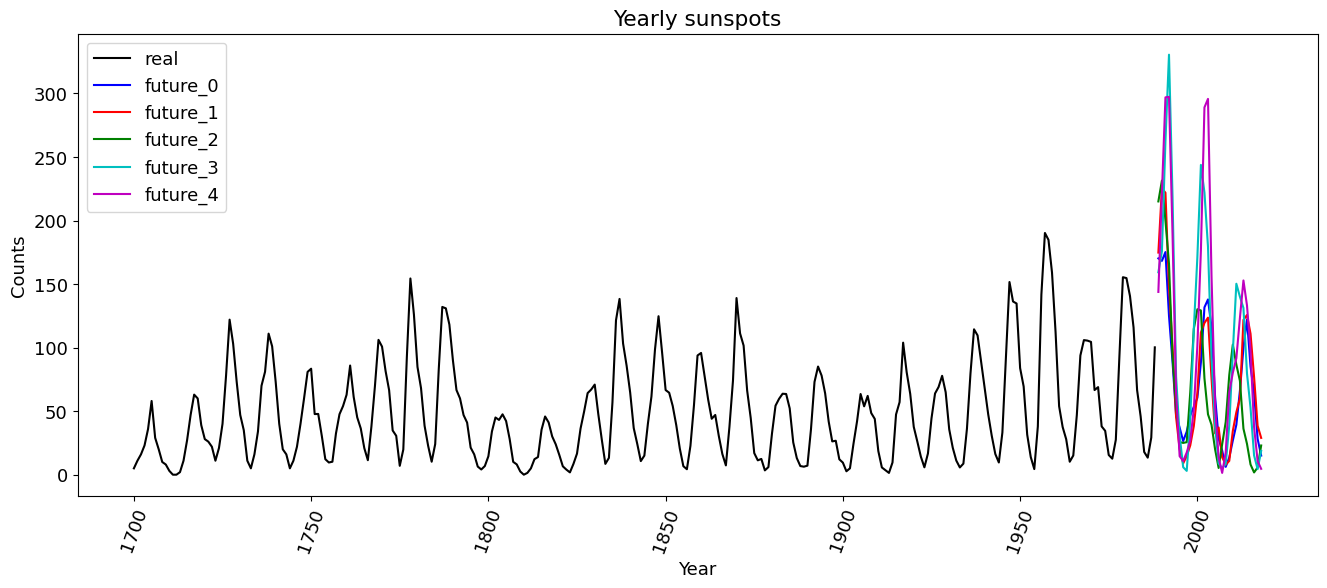

In [83]:
labels = ["real"] + [f"future_{i}" for i in range(5)]

plot_multiple_ts([ts] + ts_futures_h, labels=labels)

In [89]:
lower_ci_list = np.min(np.array(future_paths), axis=0)
max_ci_list = np.max(np.array(future_paths), axis=0)
mean_list = np.mean(np.array(future_paths), axis=0)

ts_lower_h = np.power(pd.Series(lower_ci_list, index=h_index), 2)
ts_upper_h = np.power(pd.Series(max_ci_list, index=h_index), 2)
ts_h = np.power(pd.Series(mean_list, index=h_index), 2)

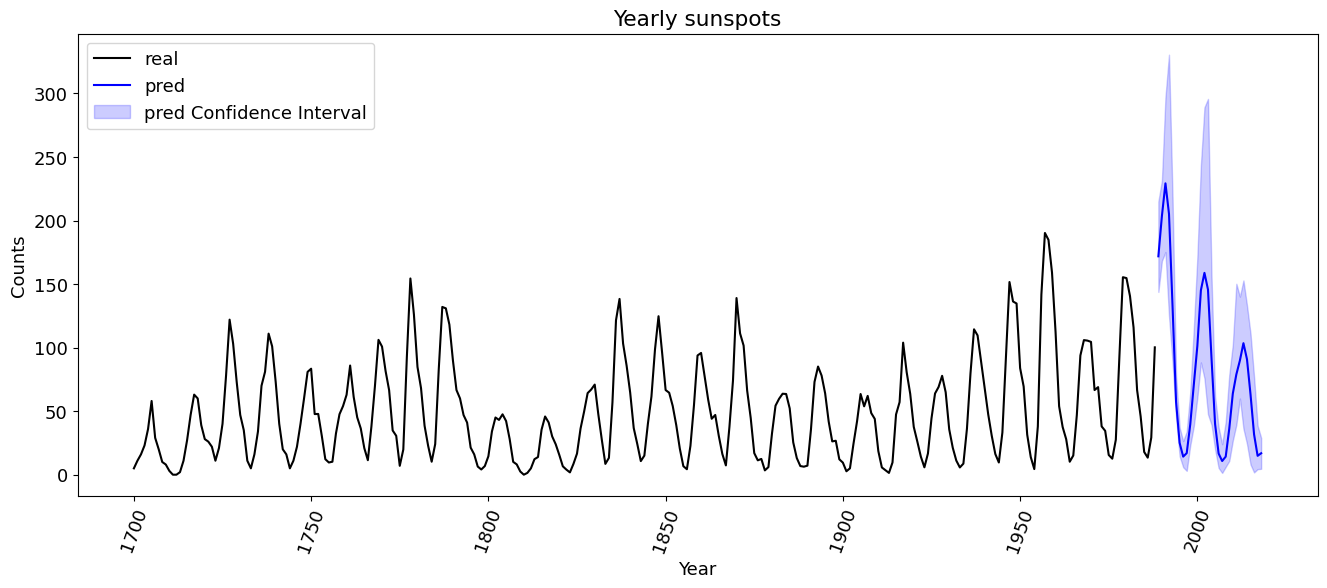

In [94]:
plot_multiple_ts(
    [ts, ts_h], 
    labels=["real", "pred"],
    lower_ci_list=[None, ts_lower_h],
    upper_ci_list=[None, ts_upper_h],
)